In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 64.9 MB/s 
     |████████████████████████████████| 8.8 MB 37.3 MB/s 
     |████████████████████████████████| 4.1 MB 44.4 MB/s 
     |████████████████████████████████| 468 kB 64.4 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.50.0
    Uninstalling grpcio-1.50.0:
      Successfully uninstalled grpcio-1.50.0


In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 7.4 MB/s 
     |████████████████████████████████| 3.5 MB 53.9 MB/s 
     |████████████████████████████████| 2.4 MB 49.0 MB/s 
     |████████████████████████████████| 709 kB 48.3 MB/s 
     |████████████████████████████████| 467 kB 7.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=6d1d1c5e9c05a824188cd8bd6787a6e94fce931eb0502b041e45e0999096b792
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import glob
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn_nn
from torch_geometric.loader import DataLoader

In [5]:
ROOT_PATH = "/content/drive/My Drive/Colab_Notebooks/surrogate/surrogate"
DATA_DIR = "GNN_dataset_24_10_2022.csv"
# os.listdir(ROOT_PATH)

genes_str0 = [f'genes_0_{i}' for i in range(45)]
genes_str1 = [f'genes_1_{i}' for i in range(45)]
MAX_COST = 1e4

In [ ]:
# !git clone https://github.com/haiminh2001/Surrogate.git
# import shutil
# shutil.copytree("Surrogate", f"{ROOT_PATH}/source_code")

In [50]:
data_df = pd.read_csv(f'{ROOT_PATH}/{DATA_DIR}')
data_df = data_df.sort_values(by=["generation"], ignore_index=True)
data_df['skill_factor'] = data_df['skill_factor'].astype(int)
# data_df = data_df.iloc[np.arange(len(data_df) // 2)]
data_df = data_df.loc[(data_df['skill_factor'] == 0)].reset_index()
data_df

,index,genes_0_0,genes_0_1,genes_0_2,genes_0_3,genes_0_4,genes_0_5,genes_0_6,genes_0_7,genes_0_8,...,genes_1_38,genes_1_39,genes_1_40,genes_1_41,genes_1_42,genes_1_43,genes_1_44,cost,skill_factor,generation
0,11,20,24,25,13,0,22,34,4,44,...,18,34,39,14,17,24,34,82,0,0
1,18,30,14,12,35,40,37,10,2,21,...,42,32,33,13,18,25,15,10000,0,0
2,21,18,7,17,25,10,42,22,2,29,...,0,19,31,17,39,25,33,15,0,0
3,51,39,11,36,43,4,6,12,44,18,...,12,10,5,25,17,38,4,18,0,0
4,71,28,14,27,0,13,26,43,32,10,...,29,10,5,14,40,14,22,125,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,25248,0,15,42,44,39,25,37,20,29,...,18,21,16,33,4,5,43,33,0,100
995,25254,9,13,28,25,3,39,16,27,33,...,0,20,43,24,9,17,12,10000,0,100
996,25263,21,28,1,38,36,30,9,29,33,...,6,22,43,9,4,5,43,40,0,100
997,25278,25,32,0,29,14,41,16,12,33,...,25,22,22,8,9,17,28,10000,0,100


In [51]:
data_df['genes_0'] = data_df[genes_str0].agg(list, axis = 1)
data_df['genes_1'] = data_df[genes_str1].agg(list, axis = 1)
data_df['genes'] = data_df[['genes_0', 'genes_1']].agg(list, axis = 1)
data_df = data_df.drop(columns=genes_str0 + genes_str1 + ['genes_0','genes_1'])
#data_df.head()

In [52]:
data_df.head()

,index,cost,skill_factor,generation,genes
0,11,82,0,0,"[[20, 24, 25, 13, 0, 22, 34, 4, 44, 10, 26, 40..."
1,18,10000,0,0,"[[30, 14, 12, 35, 40, 37, 10, 2, 21, 5, 8, 26,..."
2,21,15,0,0,"[[18, 7, 17, 25, 10, 42, 22, 2, 29, 31, 1, 24,..."
3,51,18,0,0,"[[39, 11, 36, 43, 4, 6, 12, 44, 18, 16, 31, 38..."
4,71,125,0,0,"[[28, 14, 27, 0, 13, 26, 43, 32, 10, 7, 11, 19..."


# EDA

In [53]:
print(f"Volume of dataset: {len(data_df)}")
print(f"Number of tasks: {len(data_df['skill_factor'].unique())}")
print(f"Number of generations: {len(data_df['generation'].unique())}")

Volume of dataset: 999
Number of tasks: 1
Number of generations: 101


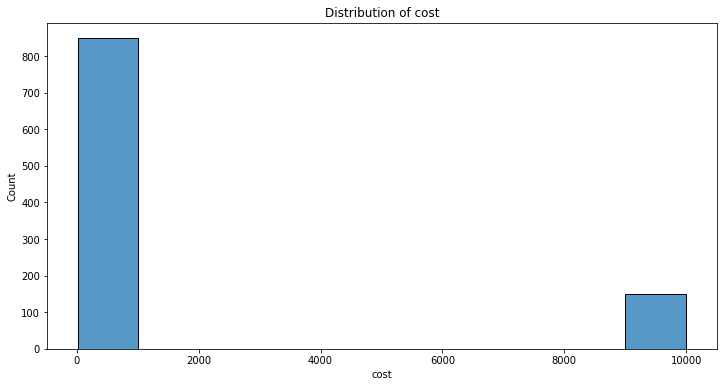

In [54]:
plt.figure(figsize=(12,6))
plt.title("Distribution of cost")
sns.histplot(data_df, x = 'cost', bins = 10)

Number of infeasible genes: 150


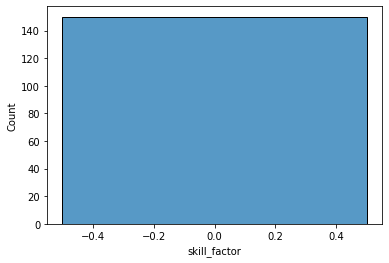

In [55]:
print(f'Number of infeasible genes: {len(data_df[data_df.cost == MAX_COST])}')
sns.histplot(data_df[data_df.cost == MAX_COST], x = 'skill_factor')

In [56]:
from sklearn.model_selection import StratifiedKFold
split_fold = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

for train_idx, valid_idx in split_fold.split(data_df, data_df[["skill_factor"]]):
  train_df = data_df.iloc[train_idx]
  valid_df = data_df.iloc[valid_idx]

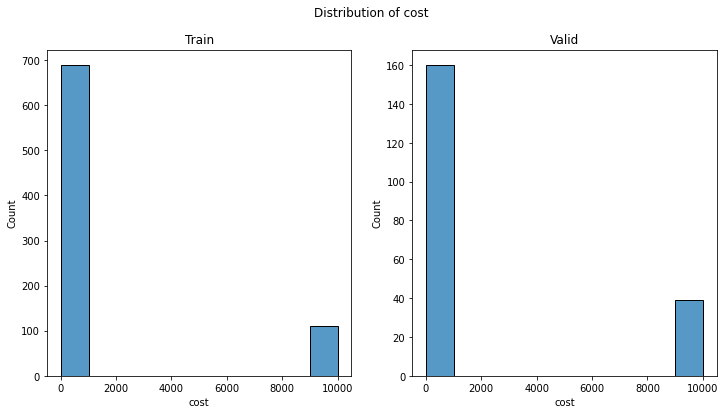

In [57]:
plt.subplots(1,2,figsize=(12,6))
plt.suptitle("Distribution of cost")

plt.subplot(1,2,1)
plt.title("Train")
sns.histplot(train_df, x = 'cost', bins = 10)
plt.subplot(1,2,2)
plt.title("Valid")
sns.histplot(valid_df, x = 'cost', bins = 10)

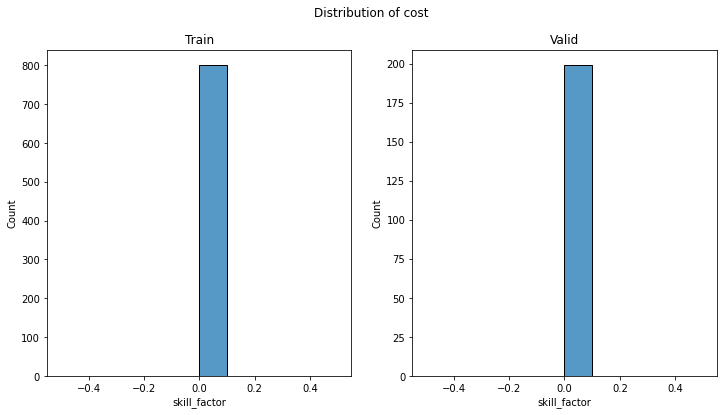

In [58]:
plt.subplots(1,2,figsize=(12,6))
plt.suptitle("Distribution of cost")

plt.subplot(1,2,1)
plt.title("Train")
sns.histplot(train_df, x = 'skill_factor', bins = 10)
plt.subplot(1,2,2)
plt.title("Valid")
sns.histplot(valid_df, x = 'skill_factor', bins = 10)

# Load task & Create dataset



```
`After folding: we have train_df + valid_df`
`Load tasks from MFEA_lib`
```



In [59]:
os.chdir(f"{ROOT_PATH}")
# import sys 
# sys.path.append(f"{ROOT_PATH}")

In [60]:
from MFEA_lib.tasks.Benchmark.IDPC_EDU import IDPC_EDU_benchmark
tasks, IndClass = IDPC_EDU_benchmark.get_tasks(1)

Reading data...


In [61]:
from MFEA_lib.tasks.surrogate import GraphDataset

def create_dataset(data_df, tasks):
  dataset = GraphDataset(tasks = tasks)
  genes = np.stack(data_df.genes)
  costs = np.hstack(data_df.cost)
  skfs = np.hstack(data_df.skill_factor)
  thresh_hold = np.array([MAX_COST for i in range(len(data_df))])
  dataset.append(genes = genes, costs = costs, skfs = skfs, thresh_hold = thresh_hold)
  return dataset

train_dataset = create_dataset(train_df, tasks)
valid_dataset = create_dataset(valid_df, tasks)
print(f"Length of train_dataset: {len(train_dataset)} | valid_dataset: {len(valid_dataset)}")

Length of train_dataset: 800 | valid_dataset: 199


# Load model & Train

In [62]:
from scipy.stats import kendalltau
from sklearn.metrics import f1_score, confusion_matrix

In [116]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class SurrogateModel(nn.Module):
    def __init__(self, in_channels, hid_channels):
        super().__init__()
        hid_channels2 = hid_channels//4
        self.gc1 = gnn_nn.GATConv(in_channels=in_channels, out_channels=hid_channels)
        self.gc2 = gnn_nn.GATConv(in_channels=hid_channels, out_channels=hid_channels)
        self.gc3 = gnn_nn.GATConv(in_channels=hid_channels, out_channels=hid_channels2)
        self.lstm = nn.LSTM(hid_channels2, hid_channels2)
        self.regress = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_channels2,1)
            )
        self.classify = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_channels2,1),
            nn.Sigmoid(),
        )
        
    def forward(self, inputs):
        vertices_feature, edge_index, edge_attr = inputs.x, inputs.edge_index, inputs.edge_attr
        x = F.relu(self.gc1(vertices_feature, edge_index, edge_attr))
        x = F.relu(self.gc2(x, edge_index, edge_attr))
        x = self.gc3(x, edge_index, edge_attr)
        x = x.squeeze(1)
        _, (_, x) = self.lstm(x)
        v = self.regress(x)
        c = self.classify(x)
        return v.flatten(), c.flatten()

In [117]:
class SurrogatePipeline():
    def __init__(self, input_dim, hidden_dim, learning_rate, num_epochs = 1, device = 'cuda', epoch_start = None):
        self.device = device
        self.model = SurrogateModel(input_dim, hidden_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.reg_criteria = nn.MSELoss()
        self.cls_criteria = nn.BCELoss()
        self.num_epochs = num_epochs
        self.eval_frequency = 2
        self.save_frequency = 1
        self.log_folder = "./checkpoints/model"
        self.load_weights_path = None
        self.epoch = 0 if epoch_start is None else epoch_start
        self.thresh_hold_cls = 0.6
        self.regress_loss_weight = 10

    def train(self, train_dataset, valid_dataset):
        print("Training surrogate")
        print(self.model)
        print(f"Number of params: {self.number_of_parameters()}")
        print(f"Length of train_dataset: {len(train_dataset)} | valid_dataset: {len(valid_dataset)}")
        print(f"Using {self.device}")
        self.save_opts()
        if self.load_weights_path is not None:
          self.load_model()


        train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory= True, num_workers= 2)
        valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory= True, num_workers= 2)
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader

        for self.epoch in range(self.epoch, self.num_epochs + self.epoch):
            self.model.train()

            losses_all = []
            losses_reg = []
            losses_cls = []
            vpreds_all = []
            vgts_all = []
            cpreds_all = []
            cgts_all = []
            skill_factor_all = []

            for _, batch in tqdm(enumerate(train_dataloader)):
                vpreds, cpreds = self.model(batch.to(self.device))

                vpreds_all += list(vpreds.detach().cpu().numpy())
                vgts_all += list(batch.y.detach().cpu().numpy())
                cpreds_all += list(cpreds.detach().cpu().numpy())
                cgts_all += list(batch.thresh_hold.detach().cpu().numpy())
             
                skill_factor_all += list(batch.skill_factor.detach().cpu().numpy())

                loss_reg = self.reg_criteria(vpreds / batch.y, torch.Tensor([1]).type(torch.float).cuda()) 
                loss_cls = self.cls_criteria(cpreds, batch.thresh_hold)
                loss = self.regress_loss_weight*loss_reg + loss_cls
                losses_reg.append(loss_reg.item())
                losses_cls.append(loss_cls.item())
                losses_all.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            metric = {}
            vpreds_all = np.array(vpreds_all)
            vgts_all = np.array(vgts_all)
            cpreds_all = np.array(cpreds_all)
            cgts_all = np.array(cgts_all)
            skill_factor_all = np.array(skill_factor_all)

            skill_factor_value = np.unique(skill_factor_all)
            cpreds_all = (np.array(cpreds_all) >= self.thresh_hold_cls).astype(float)

            for skf in skill_factor_value:
                metric[f'kendalltau_{skf}'] = kendalltau(vpreds_all[skill_factor_all == skf], vgts_all[skill_factor_all == skf])
                metric[f'f1_score_{skf}'] = f1_score(cpreds_all[skill_factor_all == skf], cgts_all[skill_factor_all == skf])
            
            losses = dict()
            losses['loss'] = np.mean(losses_all)
            losses['loss_cls'] = np.mean(losses_cls)
            losses['loss_reg'] = np.mean(losses_reg)

            self.log_terminal("Train", losses, metric)
            self.log_file("Train", losses, metric)

            if (self.epoch + 1) % self.eval_frequency == 0:
                self.eval()
            if (self.epoch + 1) % self.save_frequency == 0:
                self.save_model()
    
    def eval(self):
        self.model.eval()
        
        losses_all = []
        losses_cls = []
        losses_reg = []

        vpreds_all = []
        vgts_all = []
        cpreds_all = []
        cgts_all = []
        skill_factor_all = []

        with torch.no_grad():
            for _, batch in tqdm(enumerate(self.valid_dataloader)):
                vpreds, cpreds = self.model(batch.to(self.device))

                vpreds_all += list(vpreds.detach().cpu().numpy())
                vgts_all += list(batch.y.detach().cpu().numpy())
                cpreds_all += list(cpreds.detach().cpu().numpy())
                cgts_all += list(batch.thresh_hold.detach().cpu().numpy())
                skill_factor_all += list(batch.skill_factor.detach().cpu().numpy())

                loss_reg = self.reg_criteria(vpreds / batch.y, torch.Tensor([1]).type(torch.float).cuda()) 
                loss_cls = self.cls_criteria(cpreds, batch.thresh_hold)
                loss = self.regress_loss_weight*loss_reg + loss_cls
                losses_reg.append(loss_reg.item())
                losses_cls.append(loss_cls.item())
                losses_all.append(loss.item())
 
        metric = {}
        vpreds_all = np.array(vpreds_all)
        vgts_all = np.array(vgts_all)
        cpreds_all = np.array(cpreds_all)
        cgts_all = np.array(cgts_all)
        skill_factor_all = np.array(skill_factor_all)

        skill_factor_value = np.unique(skill_factor_all)
        cpreds_all = (np.array(cpreds_all) >= self.thresh_hold_cls).astype(float)

        for skf in skill_factor_value:
            metric[f'kendalltau_{skf}'] = kendalltau(vpreds_all[skill_factor_all == skf], vgts_all[skill_factor_all == skf])
            metric[f'f1_score_{skf}'] = f1_score(cpreds_all[skill_factor_all == skf], cgts_all[skill_factor_all == skf])
        
        losses = dict()
        losses['loss'] = np.mean(losses_all)
        losses['loss_cls'] = np.mean(losses_cls)
        losses['loss_reg'] = np.mean(losses_reg)

        self.log_terminal("Validation", losses, metric)
        self.log_file("Validation", losses, metric)

    def predict(self, input):
        with torch.no_grad():
            input.to(self.device)
            pred = self.model(input)
            return pred

    def number_of_parameters(self):
        return count_parameters(self.model)

    def log_terminal(self, mode, loss, metric):
        print_string = "epoch {} [{}] " + " | loss: {}"
        print(print_string.format(self.epoch, mode, loss))

    def log_file(self, mode, loss, metric):
        os.makedirs(self.log_folder, exist_ok=True)
        print_string = "epoch {} [{}] " + " | loss: {} | metric: {} \n"
        with open(f"{self.log_folder}/log.txt", "a") as f:
            f.write(print_string.format(self.epoch, mode, loss, metric))

    def save_opts(self):
        # os.makedirs(self.log_folder, exist_ok=True)
        # opt = self.__class__.__dict__.copy()
        # print(opt)
        # opt.pop("model")
        # opt.pop("optimizer")
        # opt.pop("reg_criteria")
        # opt.pop("cls_criteria")
        # with open(os.path.join(self.log_folder, 'opt.json'), 'w') as f:
        #     json.dump(opt, f, indent=2) 
        pass
        

    def save_model(self):
        print("Save model to:", self.log_folder)
        os.makedirs(self.log_folder, exist_ok=True)
        log_path = os.path.join(self.log_folder, "weights_{}.pth".format(self.epoch))
        torch.save(self.model.state_dict(), log_path) 

    def load_model(self):
        print("Load model from:", self.load_weights_path)
        model_dict = self.model.state_dict()
        pretrained_dict = torch.load(self.load_weights_path)
        pretrained_dict = {k: v for k,v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        self.model.load(model_dict)

    def save_pipeline(self, path):
        pass

In [118]:
sur_pl = SurrogatePipeline(input_dim = 3, hidden_dim = 256, learning_rate = 1e-4, num_epochs = 100, device = 'cuda')
sur_pl.log_folder = "./checkpoints/model_1task_v3"
sur_pl.save_frequency = 10
sur_pl.epoch = 0


In [ ]:
os.makedirs(sur_pl.log_folder, exist_ok=True)
opt = sur_pl.__dict__.copy()
opt.pop("model")
opt.pop("optimizer")
opt.pop("reg_criteria")
opt.pop("cls_criteria")
with open(os.path.join(sur_pl.log_folder, 'opt.json'), 'w') as f:
    json.dump(opt, f, indent=2)

sur_pl.train(train_dataset, valid_dataset)

Training surrogate
SurrogateModel(
  (gc1): GATConv(3, 256, heads=1)
  (gc2): GATConv(256, 256, heads=1)
  (gc3): GATConv(256, 64, heads=1)
  (lstm): LSTM(64, 64)
  (regress): Sequential(
    (0): ReLU()
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
  (classify): Sequential(
    (0): ReLU()
    (1): Linear(in_features=64, out_features=1, bias=True)
    (2): Sigmoid()
  )
)
Number of params: 117826
Length of train_dataset: 800 | valid_dataset: 199
Using cuda


800it [00:22, 35.02it/s]

epoch 0 [Train]  | loss: {'loss': 5.142177211306989, 'loss_cls': 0.42549524721689524, 'loss_reg': 0.47166819585278313}



800it [00:22, 34.93it/s]

epoch 1 [Train]  | loss: {'loss': 4.756208850210532, 'loss_cls': 0.4049049377441406, 'loss_reg': 0.43513039152645716}



199it [00:04, 45.98it/s]

epoch 1 [Validation]  | loss: {'loss': 5.250890382570238, 'loss_cls': 0.5175651169976397, 'loss_reg': 0.4733325252106291}



800it [00:26, 30.45it/s]

epoch 2 [Train]  | loss: {'loss': 4.756213805694133, 'loss_cls': 0.40557605541311204, 'loss_reg': 0.4350637764596439}



800it [00:23, 34.62it/s]

epoch 3 [Train]  | loss: {'loss': 4.768574890019372, 'loss_cls': 0.4157137676561251, 'loss_reg': 0.4352861128607071}



199it [00:04, 45.10it/s]

epoch 3 [Validation]  | loss: {'loss': 5.241627368495692, 'loss_cls': 0.5173514586447472, 'loss_reg': 0.4724275938253651}



800it [00:23, 34.64it/s]

epoch 4 [Train]  | loss: {'loss': 4.756820210302249, 'loss_cls': 0.4066578992269933, 'loss_reg': 0.4350162315098555}



800it [00:23, 34.12it/s]

epoch 5 [Train]  | loss: {'loss': 4.753998297005892, 'loss_cls': 0.40503697835840285, 'loss_reg': 0.43489613220157963}



199it [00:04, 45.28it/s]


epoch 5 [Validation]  | loss: {'loss': 5.230741841259913, 'loss_cls': 0.5074484000104157, 'loss_reg': 0.4723293463425739}


800it [00:23, 34.77it/s]

epoch 6 [Train]  | loss: {'loss': 4.755266478266567, 'loss_cls': 0.4045114395860583, 'loss_reg': 0.4350755031172997}



800it [00:23, 34.14it/s]

epoch 7 [Train]  | loss: {'loss': 4.765928904227913, 'loss_cls': 0.41007423475384713, 'loss_reg': 0.4355854682154049}



199it [00:04, 45.92it/s]

epoch 7 [Validation]  | loss: {'loss': 5.226151851515974, 'loss_cls': 0.49851694332445085, 'loss_reg': 0.4727634912289898}



800it [00:22, 34.86it/s]

epoch 8 [Train]  | loss: {'loss': 4.761733663165942, 'loss_cls': 0.40974799065850676, 'loss_reg': 0.43519856856500083}



800it [00:24, 32.50it/s]

epoch 9 [Train]  | loss: {'loss': 4.754971958315, 'loss_cls': 0.40542810880579055, 'loss_reg': 0.4349543850452507}



199it [00:04, 46.30it/s]

epoch 9 [Validation]  | loss: {'loss': 5.236927496428466, 'loss_cls': 0.512100220962086, 'loss_reg': 0.47248272618571946}
Save model to: ./checkpoints/model_1task_v3



800it [00:22, 34.79it/s]


epoch 10 [Train]  | loss: {'loss': 4.754817235674709, 'loss_cls': 0.4051067807339132, 'loss_reg': 0.43497104560869104}


800it [00:23, 34.66it/s]

epoch 11 [Train]  | loss: {'loss': 4.756573220267892, 'loss_cls': 0.40569555930793283, 'loss_reg': 0.43508776552238715}



199it [00:04, 45.86it/s]

epoch 11 [Validation]  | loss: {'loss': 5.233292729036892, 'loss_cls': 0.5060520353329242, 'loss_reg': 0.47272406923912974}



800it [00:23, 34.65it/s]

epoch 12 [Train]  | loss: {'loss': 4.753671144107357, 'loss_cls': 0.4047239132318646, 'loss_reg': 0.43489472271219426}



800it [00:23, 34.54it/s]

epoch 13 [Train]  | loss: {'loss': 4.755160260889679, 'loss_cls': 0.40564355712383987, 'loss_reg': 0.4349516709996142}



199it [00:04, 46.42it/s]

epoch 13 [Validation]  | loss: {'loss': 5.234152479013007, 'loss_cls': 0.505492567566771, 'loss_reg': 0.4728659900651951}



800it [00:22, 34.92it/s]

epoch 14 [Train]  | loss: {'loss': 4.751906536575407, 'loss_cls': 0.403485801294446, 'loss_reg': 0.43484207345338177}



800it [00:22, 34.96it/s]

epoch 15 [Train]  | loss: {'loss': 4.756219347175211, 'loss_cls': 0.40676117504015563, 'loss_reg': 0.43494581707534963}



199it [00:04, 46.35it/s]

epoch 15 [Validation]  | loss: {'loss': 5.291042863162019, 'loss_cls': 0.5683458325401622, 'loss_reg': 0.4722697037194935}



800it [00:22, 35.38it/s]

epoch 16 [Train]  | loss: {'loss': 4.754748630281537, 'loss_cls': 0.4086997791286558, 'loss_reg': 0.4346048846138709}



800it [00:24, 32.07it/s]


epoch 17 [Train]  | loss: {'loss': 4.7551236301008615, 'loss_cls': 0.40528931823559106, 'loss_reg': 0.43498343213577073}


199it [00:04, 45.95it/s]

epoch 17 [Validation]  | loss: {'loss': 5.240106815818566, 'loss_cls': 0.5093549996913977, 'loss_reg': 0.47307518119338193}



800it [00:22, 34.92it/s]


epoch 18 [Train]  | loss: {'loss': 4.754614020995795, 'loss_cls': 0.40458944951184095, 'loss_reg': 0.43500245776338514}


800it [00:22, 35.28it/s]

epoch 19 [Train]  | loss: {'loss': 4.754233950590715, 'loss_cls': 0.40379892769735304, 'loss_reg': 0.4350435023230777}



199it [00:04, 46.08it/s]

epoch 19 [Validation]  | loss: {'loss': 5.25472224664748, 'loss_cls': 0.5251921372272861, 'loss_reg': 0.47295301130145073}
Save model to: ./checkpoints/model_1task_v3



800it [00:23, 34.71it/s]

epoch 20 [Train]  | loss: {'loss': 4.75404719718732, 'loss_cls': 0.40602572733536363, 'loss_reg': 0.434802147822965}



800it [00:23, 34.77it/s]

epoch 21 [Train]  | loss: {'loss': 4.752503867028281, 'loss_cls': 0.4062098061386496, 'loss_reg': 0.434629405450806}



199it [00:04, 46.43it/s]

epoch 21 [Validation]  | loss: {'loss': 5.225474208743129, 'loss_cls': 0.49603129376718147, 'loss_reg': 0.47294429337409893}



800it [00:22, 35.30it/s]

epoch 22 [Train]  | loss: {'loss': 4.754116524625569, 'loss_cls': 0.40292333303019406, 'loss_reg': 0.4351193203329177}



800it [00:22, 35.12it/s]

epoch 23 [Train]  | loss: {'loss': 4.756547076040879, 'loss_cls': 0.4063971125101671, 'loss_reg': 0.43501499596042775}



199it [00:04, 46.88it/s]

epoch 23 [Validation]  | loss: {'loss': 5.245997082797726, 'loss_cls': 0.5118641592000597, 'loss_reg': 0.4734132933854792}



617it [00:18, 25.91it/s]